In [28]:
#setup the environment for the NN, depending on if it to be run on Google Colab, or a local device (with or without a CUDA-enable GPU)

import os
import csv
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style
#set up environment
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.
GOOGLE_COLAB = False #set to true if running in google colab, false other wise
INCLUDE_POST_MATCH = True #set to true if you want to include the post match data

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

if GOOGLE_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    training_data_filename = "/content/gdrive/My Drive/Colab Notebooks/LoL-Predictor/datasets/training_data.csv" #for running on google colab notebooks
    model_log_filename = "/content/gdrive/My Drive/Colab Notebooks/LoL-Predictor/logs/model.log"
    numpy_training_data = "/content/gdrive/My Drive/Colab Notebooks/LoL-Predictor/datasets/training_data.npy"
    if INCLUDE_POST_MATCH:
        excluded_columns_file = "/content/gdrive/My Drive/Colab Notebooks/LoL-Predictor/docs/PostMatchExcludedColumns.csv"
    else:
         excluded_columns_file = "/content/gdrive/My Drive/Colab Notebooks/LoL-Predictor/docs/PreMatchExcludedColumns.csv"
else:
    training_data_filename = "C:\\Users\\James Ting\\OneDrive - McGill University\\Personal\\Personal Projects\\LoL-Predictor\\datasets\\training_data.csv"
    model_log_filename = "C:\\Users\\James Ting\\OneDrive - McGill University\\Personal\\Personal Projects\\LoL-Predictor\\logs\\model.log"
    numpy_training_data = "C:\\Users\\James Ting\\OneDrive - McGill University\\Personal\\Personal Projects\\LoL-Predictor\\datasets\\training_data.npy"
    if INCLUDE_POST_MATCH:
        excluded_columns_file = "C:\\Users\\James Ting\\OneDrive - McGill University\\Personal\\Personal Projects\\LoL-Predictor\\docs\\PostMatchExcludedColumns.csv"
    else:
        excluded_columns_file = "C:\\Users\\James Ting\\OneDrive - McGill University\\Personal\\Personal Projects\\LoL-Predictor\\docs\\PreMatchExcludedColumns.csv"
        

Running on the GPU
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
class DataSetReader():
    LABELS = {'blue_win':[1,0] , 'red_win':[0,1]}
    training_data = []
    blue_win_count = 0
    red_win_count = 0
    training_data_location = training_data_filename
    exclude_columns_indices = None
    with open(excluded_columns_file,"r") as f:
      reader = csv.reader(f)
      exclude_columns_indices = tuple(next(reader))
      

    def read_training_data(self):
      with open(self.training_data_location,'r') as f:
        next(f) #skip the line with the column names
        for row in f:
          matchData = self.read_and_exclude_row(row,DataSetReader.exclude_columns_indices)
          result = None
          if(matchData[-1] == 1): #red win, blue loos
            result = self.LABELS["red_win"]
            self.red_win_count += 1
          elif (matchData[-1] == 0): #red loss, blue win
            result = self.LABELS["blue_win"]
            self.blue_win_count += 1
          else:
            raise TypeError
          self.training_data.append([np.array(matchData[:-2]),result])
      f.close()
      np.random.shuffle(self.training_data)
      np.save(numpy_training_data, self.training_data)
      print('Blue Win Count:',self.blue_win_count)
      print('Red Win Count:', self.red_win_count)
          
          

    def read_and_exclude_row(self,row,exclude_column_indices):
        row_list = row.split(',')
        cleaned_row = []
        append = cleaned_row.append
        for index,value in enumerate(row_list):
            if str(index) not in exclude_column_indices:
              if value == 'FALSE' or value == 'False':
                append(0)
              elif value == 'TRUE' or value == 'True':
                append(1)
              else:
                append(float(value))
        return cleaned_row

    def get_input_size(self):
      return len(self.training_data[0][0])
    
    def get_training_set(self):
      return self.training_data


In [30]:
if REBUILD_DATA:
  data_reader = DataSetReader()
  data_reader.read_training_data()
  INPUT_SIZE = data_reader.get_input_size()

Blue Win Count: 2438
Red Win Count: 2438


In [0]:
class Net(nn.Module):
    #constructor
    def __init__(self,layer_size):
        super().__init__() #superclass constructor
        self.fc1 = nn.Linear(INPUT_SIZE,layer_size)
        self.fc2 = nn.Linear(layer_size,layer_size)
        self.fc3 = nn.Linear(layer_size,2)

        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm = nn.BatchNorm1d(layer_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.batchnorm(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [32]:
trainset = np.load(numpy_training_data,allow_pickle=True)
print("Size of data set:",len(trainset))

loss_function = nn.BCEWithLogitsLoss()

X = torch.Tensor([i[0] for i in trainset])
X = torch.log10(X + torch.ones(INPUT_SIZE)) #normalize the data to put it through a log(x+1) function
y = torch.Tensor([i[1] for i in trainset])

VAL_PERCENT = 0.1
val_size = int(len(X)*VAL_PERCENT)

train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]

BATCH_SIZE = 200
EPOCHS = 5

Size of data set: 4876


In [0]:
def forward_pass(X,y,train = False):
    if train:
        optimizer.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i,0) == torch.argmax(j,0) for i,j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs,y)

    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = forward_pass(X.view(-1,INPUT_SIZE).to(device), y.to(device).view(-1,2))
    return val_acc, val_loss

def train(net,model_name):
    with open(model_log_filename,"a+") as f:
        for epoch in range(EPOCHS):
                for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:100] ..for now just to dev
                    batch_X = train_X[i:i+BATCH_SIZE].view(-1,INPUT_SIZE)
                    batch_y = train_y[i:i+BATCH_SIZE].view(-1,2)
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                    acc, loss = forward_pass(batch_X, batch_y, train=True)
                    if i % BATCH_SIZE == 0:
                        val_acc, val_loss = test(size=BATCH_SIZE)
                        f.write(f"{model_name},{round(float(time.time()),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")


def create_acc_loss_graph(model_name,save_graphs=False):
    contents = open(model_log_filename,"r").read().split("\n")
    times = []
    accuracies = []
    losses = []
    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")
            times.append(timestamp)
            accuracies.append(acc)
            losses.append(loss)

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    #accuracy graph
    fog = plt.figure()
    ax1 = plt.subplot2grid((2,1),(0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    ax1.plot(times, accuracies, label="test_acc",color="red")
    
    ax1.axes.get_xaxis().set_ticks([])
    ax1.legend(loc=2)
    ax1.set_title("Testing and Valdiation Accuracy")
   
    ax2.plot(times,val_accs, label="val_acc")
    ax2.legend(loc=2)
    ax2.set_title("Testing and Validation Loss")

    if save_graphs:
        plt.savefig(f"../logs/graphs/{model_name}-POSTMATCHDATA-{INCLUDE_POST_MATCH}-acccuracies.png")
    plt.show()


    #loss graph
    fog = plt.figure()
    ax1 = plt.subplot2grid((2,1),(0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
    
    ax1.plot(times,losses, label="test_loss",color="red")
    ax1.axes.get_xaxis().set_ticks([])
    ax1.axes.get_yaxis().set_ticks([])
    ax1.legend(loc=2)
    
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    
    if save_graphs:
         plt.savefig(f"../logs/graphs/{model_name}-POSTMATCHDATA-{INCLUDE_POST_MATCH}-losses.png")
    plt.show()

100%|██████████| 22/22 [00:01<00:00, 17.12it/s]


Hidden Layer size of: 32


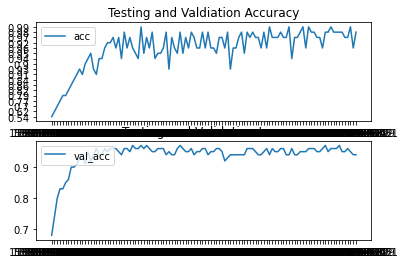

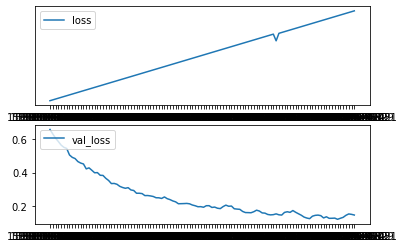

100%|██████████| 22/22 [00:01<00:00, 17.08it/s]


Hidden Layer size of: 64


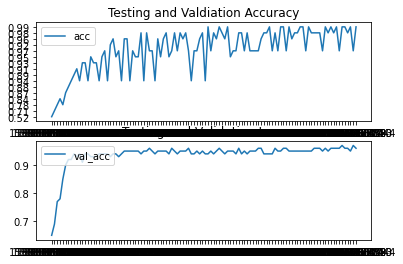

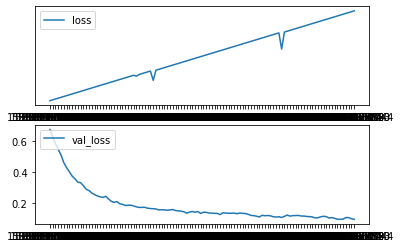

100%|██████████| 22/22 [00:01<00:00, 16.68it/s]


Hidden Layer size of: 128


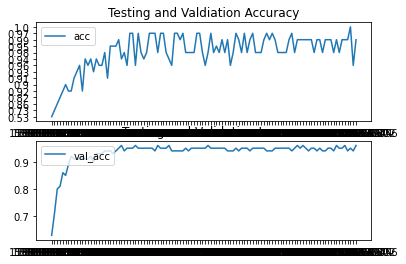

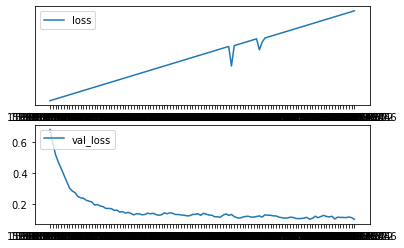

100%|██████████| 22/22 [00:01<00:00, 16.70it/s]


Hidden Layer size of: 256


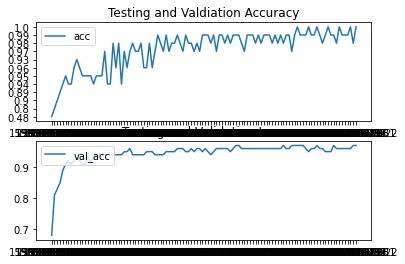

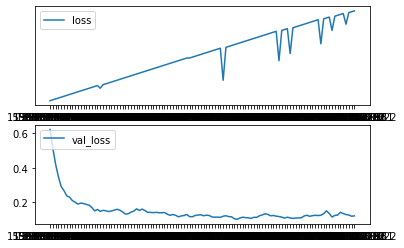

100%|██████████| 22/22 [00:01<00:00, 16.59it/s]


Hidden Layer size of: 512


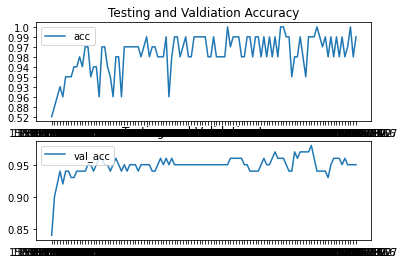

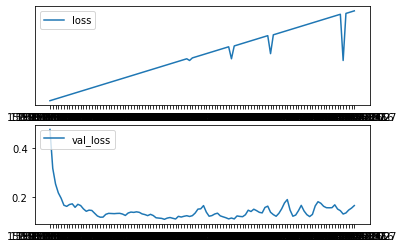

100%|██████████| 22/22 [00:01<00:00, 16.64it/s]


Hidden Layer size of: 1024


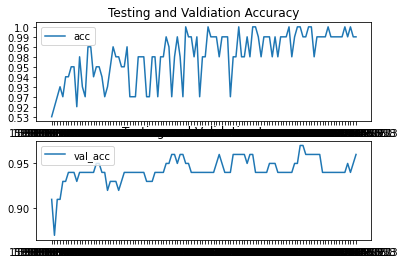

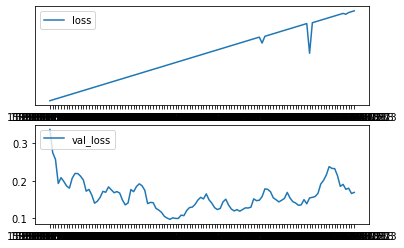

100%|██████████| 22/22 [00:01<00:00, 15.09it/s]


Hidden Layer size of: 2048


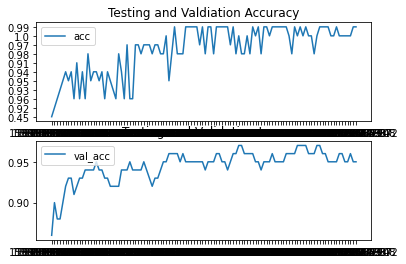

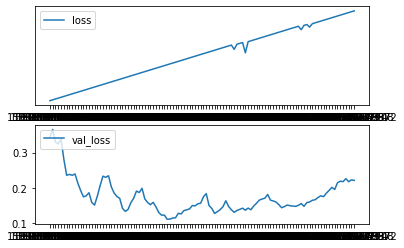

In [35]:
layer_sizes = [32,64,128,256,512,1024,2048]
save_graphs = False
for layer_size in layer_sizes:
      net = Net(layer_size).to(device)
      optimizer = optim.Adam(net.parameters(),lr = 0.001)
      model_name = f"model-layersize{layer_size}-{int(time.time())}"
      train(net,model_name)
      print("Hidden Layer size of:",layer_size)
     
      create_acc_loss_graph(model_name,save_graphs)